# Lab assignment 1: `Classification`
+ Ana Rotella Fernandez
+ Marta Simón Pinacho
+ Ana Miguélez Martínez

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


# Other
from mltools import classification_tools as CT
from mltools import model_tools as MT



## 1. Exploratory Data Analysis (EDA)

### STEP 1: IMPORT DATASET

En primer lugar, hemos importado el dataset Diabetes.csv y lo hemos guardado en la variable ‘diabetes’. Hemos imprimido la tabla para observar las variables con las que vamos a trabajar

In [38]:
### Load file --------------------------------------------
diabetes = pd.read_csv('Diabetes.csv', sep = ";")
diabetes

,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Tenemos 768 filas y 9 variables o columnas. De estas 9 variables, hay 8 variables de entrada 1 una de salida.
Las variables de entrada:
-	PREGNANT
-	GLUCOSE
-	BLOODPRESS
-	BODYMASSINDEX
-	INSULIN
-	SKINTHICKNESS
-	PEDIGREEFUNC
-	AGE

La variable de salida:
-	DIABETES


Aqui podemos ver que tenemos 9 variables, 7 de tipo int64 y 2 de tipo float64

In [39]:
### Info and type of variables & missing, veo cuantos valores non-null para todos los variables
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PREGNANT       768 non-null    int64  
 1   GLUCOSE        768 non-null    int64  
 2   BLOODPRESS     768 non-null    int64  
 3   SKINTHICKNESS  768 non-null    int64  
 4   INSULIN        768 non-null    int64  
 5   BODYMASSINDEX  768 non-null    float64
 6   PEDIGREEFUNC   768 non-null    float64
 7   AGE            768 non-null    int64  
 8   DIABETES       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### STEP 2: CHECK OUT THE MISSING VALUES

Vemos cuantos valores non-null hay para cada una de las variables

In [40]:
# How many NAs?
print('Number of NAs in dataframe:',diabetes.isnull().values.sum()) 
diabetes.isnull().any() # Are there any NAs? No,there are not any NAs

Number of NAs in dataframe: 0


PREGNANT         False
GLUCOSE          False
BLOODPRESS       False
SKINTHICKNESS    False
INSULIN          False
BODYMASSINDEX    False
PEDIGREEFUNC     False
AGE              False
DIABETES         False
dtype: bool

Como hemos comprobado, ninguna de las variables tiene non-null valores, por lo que no es necesario eliminarlos

### STEP 3: PLOT THE DATA AND CHECK OUT FOR OUTLIERS

Hacemos un describe para cada una de las variables para ver el número de observaciones, la media, la desviacion típica, el mínimo, el máximo y los cuartiles del 25%, 50% y el 75%.

In [41]:
diabetes.describe()

,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### `Functions to obtain outliers, drop outliers, generate histograms and boxplots for each variable`

Creamos 4 funciones que posteriormente aplicaremos a cada una de las variables
+ Función para obtener outliers
+ Función para eliminar outliers
+ Función para obtener un boxplot con DIABETES=1 y DIABETES=0
+ Función para realizar un histograma y un density plot


In [42]:
# FUNCIÓN PARA OBTENER OUTLIERS
def outliers (datos):
    df_iqr = stats.iqr(datos)
    print(f"Rango intercuartílico: {df_iqr}")
    # Para localizar el primer y tercer cuartil.
    df_q1, df_q3 = np.quantile(datos, [0.25, 0.75])
 
    # Limites de los valores atípicos
    cut_low = df_q1 - 1.5 * df_iqr
    cut_high = df_q3 + 1.5 * df_iqr
 
    print("Lower and upper outlier limits:", cut_low, ", ", cut_high)
 
    # Obtenemos de nuestro dataset todos los valores atípicos segun los limites calculados
    df_outliers = diabetes.loc[(datos < cut_low) | (datos > cut_high)]

    # Representación mediante boxpots (sección gráficos)

    print('We have a total of', len(df_outliers), 'outliers')

    return df_outliers

In [43]:
# FUNCION PARA ELIMINAR OUTLIERS
def drop_outliers(df_outliers):
    df_outliers_index = df_outliers.index
    diabetes_new = diabetes.copy()
    # ignoramos los errores para evitar borrar una misma fila (outliers en varias variables) dos veces
    diabetes_new.drop(index = df_outliers_index, inplace = True, errors='ignore')
    print("Outliers deleted.")

In [44]:
# FUNCIÓN PARA OBTENER UN BOXPLOT CON DIABETES=0 Y DIABETES=1
def boxplt (column, title, by=1):
    if by == 1:
        diabetes.plot.box(column=column, by = 'DIABETES')
    else:
        diabetes.plot.box(column=column)
    plt.xlabel('DIABETES', fontdict={'fontsize':20})
    plt.ylabel(column, fontdict={'fontsize':20})
    plt.title(title, fontdict={'fontsize':25})
    plt.show()

In [45]:
# FUNCIÓN PARA REALIZAR UN HISTOGRAMA Y UN DENSITY PLOT
def hist_densplt(column, title):
    sns.set()
    dens_plot = sns.histplot(data = diabetes, x = column, kde=True)
    plt.title(title, fontdict={'fontsize':25})
    dens_plot.lines[0].set_color('red')
    dens_plot.lines[0].set_linewidth(3)

Hacemos un análisis de cada una de las output variables para decidir si eliminamos los outliers o no:

## PREGNANT

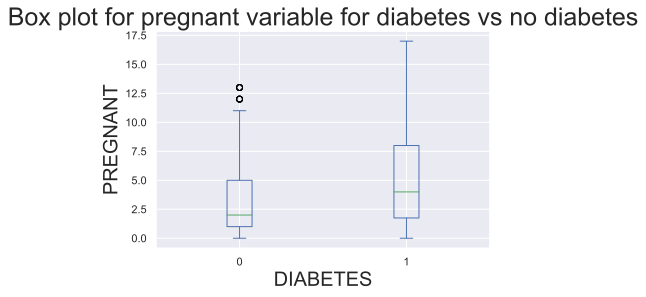

In [46]:
# Boxplot
pregnant_boxplt = boxplt('PREGNANT', 'Box plot for pregnant variable for diabetes vs no diabetes')

Esta variable tiene un total de 4 outliers, que como podemos observar en la siguiente tabla, se encuentran en las filas 88, 159, 298 y 455, con los valores 15, 17 y 14.

In [47]:
# Outliers
pregnant_outl = outliers(diabetes.PREGNANT)
pregnant_outl

Rango intercuartílico: 5.0
Lower and upper outlier limits: -6.5 ,  13.5
We have a total of 4 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
88,15,136,70,32,110,37.1,0.153,43,1
159,17,163,72,41,114,40.9,0.817,47,1
298,14,100,78,25,184,36.6,0.412,46,1
455,14,175,62,30,0,33.6,0.212,38,1


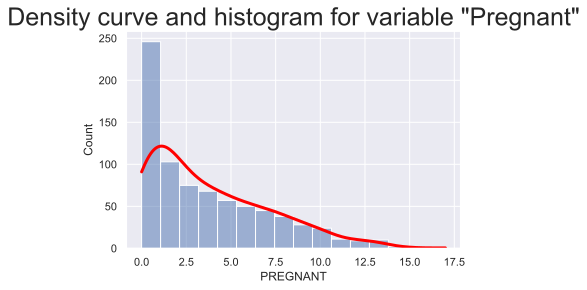

In [48]:
pregnant_histplt = hist_densplt('PREGNANT', 'Density curve and histogram for variable "Pregnant"')

**Conclusión de los outliers para PREGNANT**

En esta variable, la mayoría de casos se dan en 0, 1 y 2 embarazos, como podemos ver en el histograma. 0 embarazos se trata de un caso normal, y 14, 15 y 17 embarazos no es muy probable, pero también se puede dar el caso.

Al tratarse de valores que se pueden dar en la realidad, hemos decidido no eliminar o sustituir los outliers.

## GLUCOSE

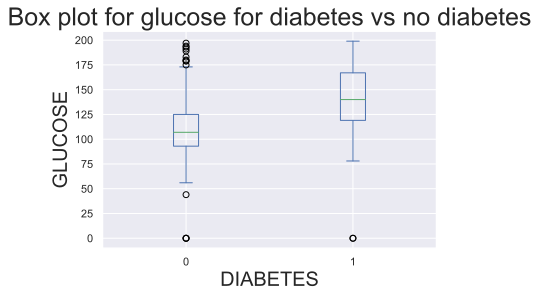

In [49]:
# Boxplot
glucose_boxplt = boxplt('GLUCOSE', 'Box plot for glucose for diabetes vs no diabetes')

In [50]:
# Outliers
glucose_outl = outliers(diabetes.GLUCOSE)
glucose_outl

Rango intercuartílico: 41.25
Lower and upper outlier limits: 37.125 ,  202.125
We have a total of 5 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


**Conclusión de los outliers para GLUCOSE**

La variable `GLUCOSE` tiene un total de 5 outliers, todos con un valor de 0, como podemos apreciar en el boxplot y en la tabla.

El bajo nivel de azucar en sangre es una grave emergencia médica. Esto puede ocasionar crisis epilépticas y daño cerebral. Con un nivel de azucar en sangre por debajo de los 70 mg/dL se considera bajo.

Por esta razón, en esta variable hemos decidido eliminar los outliers, ya que un nivel de glucosa igual a 0 es imposible en una persona que esté viva.


## BLOODPRESS

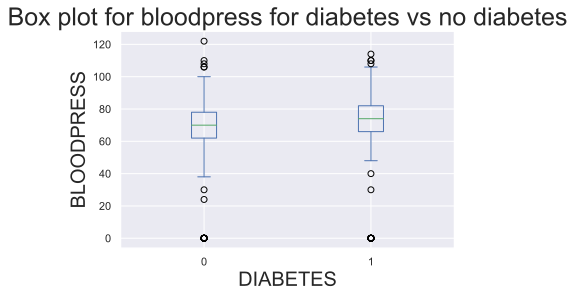

In [51]:
# Boxplot
bloodpress_boxplt = boxplt('BLOODPRESS', 'Box plot for bloodpress for diabetes vs no diabetes')

In [52]:
# Outliers
bloodpress_outl = outliers(diabetes.BLOODPRESS)
bloodpress_outl

Rango intercuartílico: 18.0
Lower and upper outlier limits: 35.0 ,  107.0
We have a total of 45 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
7,10,115,0,0,0,35.3,0.134,29,0
15,7,100,0,0,0,30.0,0.484,32,1
18,1,103,30,38,83,43.3,0.183,33,0
43,9,171,110,24,240,45.4,0.721,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
78,0,131,0,0,0,43.2,0.270,26,1
81,2,74,0,0,0,0.0,0.102,22,0
84,5,137,108,0,0,48.8,0.227,37,1
106,1,96,122,0,0,22.4,0.207,27,0


**Conclusión de los outliers para BLOODPRESS**

La variable `BLOODPRESS` tiene un total de 45 outliers. En la tabla solo hemos mostrado una parte de los outliers. 

El valor mínimo de esta variable es 0, esto significa que la presión arterial es demasiado baja, lo que puede provocar la disminución de los niveles de oxígeno del cuerpo y provocar daño al corazón y al cerebro.

Por otra parte, el valor máximo de presión arterial es 122, en torno a 80 en adelante ya se considera una presión arterial alta.

Por ambas razones, hemos decidido eliminar los outliers de esta variable.


## BODYMASSINDEX

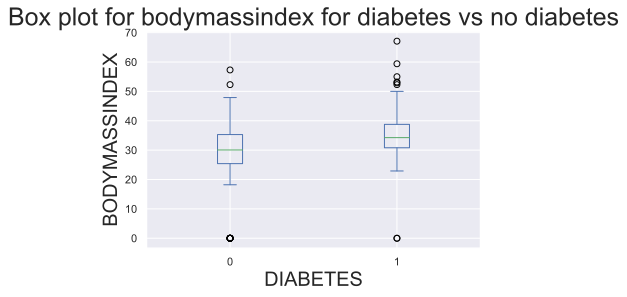

In [53]:
# Boxplot
bodymassindex_boxplt = boxplt('BODYMASSINDEX', 'Box plot for bodymassindex for diabetes vs no diabetes')

In [54]:
# Outliers
bodymassindex_outl = outliers(diabetes.BODYMASSINDEX)
bodymassindex_outl

Rango intercuartílico: 9.3
Lower and upper outlier limits: 13.35 ,  50.550000000000004
We have a total of 19 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
120,0,162,76,56,100,53.2,0.759,25,1
125,1,88,30,42,99,55.0,0.496,26,1
145,0,102,75,23,0,0.0,0.572,21,0
177,0,129,110,46,130,67.1,0.319,26,1
193,11,135,0,0,0,52.3,0.578,40,1
247,0,165,90,33,680,52.3,0.427,23,0


**Conclusión de los outliers para BODYMASSINDEX**

La variable `BODYMASSINDEX` indica el índice de masa corporal, que se mide teniendo en cuenta el peso y la altura de cada persona.

Hay un total de 19 outliers, de los cuales, 11 tienen valor 0, esto significaría que la persona carecería de masa corporal, lo cual es imposible.

Por esta razón, hemos decidido eliminar los outliers de esta variable.


## INSULIN

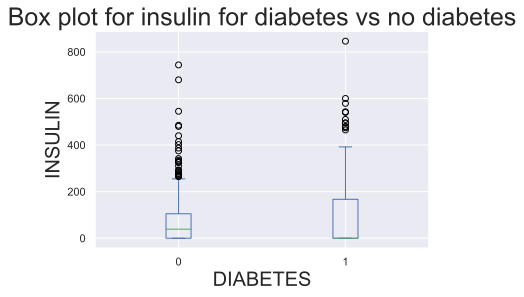

In [55]:
# Boxplot
insulin_boxplt = boxplt('INSULIN', 'Box plot for insulin for diabetes vs no diabetes')

In [56]:
# Outliers
insulin_outl = outliers(diabetes.INSULIN)
insulin_outl

Rango intercuartílico: 127.25
Lower and upper outlier limits: -190.875 ,  318.125
We have a total of 34 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
54,7,150,66,42,342,34.7,0.718,42,0
111,8,155,62,26,495,34.0,0.543,46,1
139,5,105,72,29,325,36.9,0.159,28,0
153,1,153,82,42,485,40.6,0.687,23,0
186,8,181,68,36,495,30.1,0.615,60,1
220,0,177,60,29,478,34.6,1.072,21,1
228,4,197,70,39,744,36.7,2.329,31,0
231,6,134,80,37,370,46.2,0.238,46,1


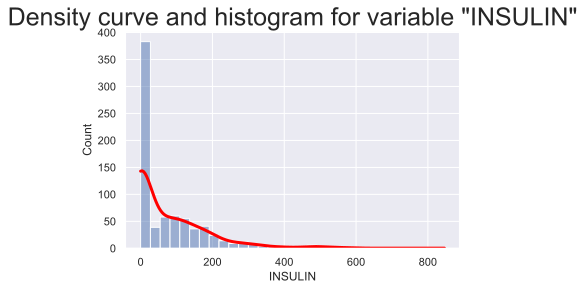

In [57]:
insulin_histplt = hist_densplt('INSULIN', 'Density curve and histogram for variable "INSULIN"')

**Conclusión de los outliers para INSULIN**

La variable `INSULIN` tiene un total de 34 outliers. 

En esta variable lo normal es que los valores se encuentren entre 5-26 U/ml. Por lo que en la gráfica de esta variable es normal encontrar valores cercanos a 0.

Si una persona tiene 300 U/ml de insulina o más en el torrente sanguíneo puede causar hipoglucemia.

Los outliers que se sitúan en valores mayores a 318.125 U/ml (que es el límite superior) son casos que se pueden dar en la realidad, por lo que hemos decidido no eliminar o sustituir los outliers de esta variable.


## SKINTHICKNESS

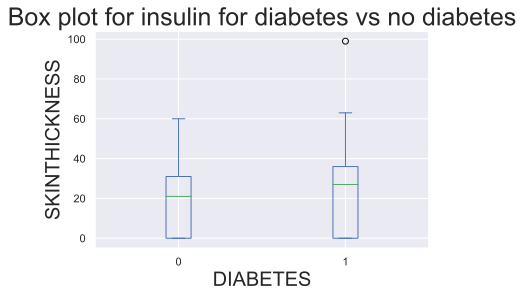

In [58]:
# Boxplot
skinthickness_boxplt = boxplt('SKINTHICKNESS', 'Box plot for insulin for diabetes vs no diabetes')

In [59]:
# Outliers
skinthickness_outl = outliers(diabetes.SKINTHICKNESS)
skinthickness_outl

Rango intercuartílico: 32.0
Lower and upper outlier limits: -48.0 ,  80.0
We have a total of 1 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
579,2,197,70,99,0,34.7,0.575,62,1


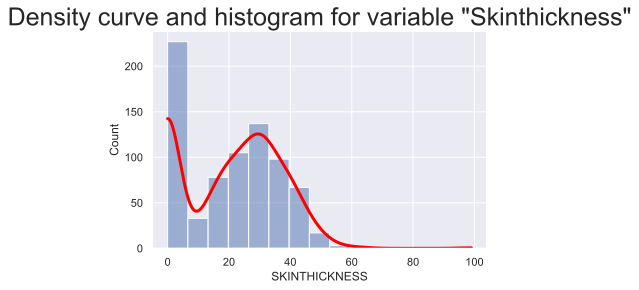

In [60]:
skinthickness_histplt = hist_densplt('SKINTHICKNESS', 'Density curve and histogram for variable "Skinthickness"')

In [61]:
len(diabetes.loc[diabetes.SKINTHICKNESS == 0])

227

**Conclusión de los outliers para SKINTHICKNESS**

La variable `SKINTHICKNESS` tiene tan solo un outlier, con un valor de 99, que como podemos ver en el boxplot se aleja bastante del resto de los datos. Al tratarse de un caso aislado en comparación con el resto de los valores de la variable, hemos decidido eliminar el outlier de esta variable.

Por otra parte, hemos observado que tenemos una gran cantidad de ceros en la variable (227 en total), por lo que hemos decidido graficarla. Esta medida no es un valor normal para medir el grosor de la piel, por lo que suponemos que son medidas que no se tomaron en el momento de analizar al paciente. 

Hay 227 variables que no aportan información a la variable, es decir, un 29.55% sobre el total. Por esta razón, es una variable que no utilizaremos para entrenar los modelos.


## PEDIGREEFUNC

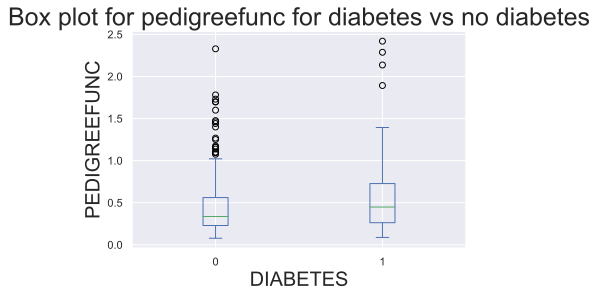

In [62]:
# Boxplot
pedigreefunc_boxplt = boxplt('PEDIGREEFUNC', 'Box plot for pedigreefunc for diabetes vs no diabetes')

In [63]:
# Outliers
pedigreefunc_outl = outliers(diabetes.PEDIGREEFUNC)
pedigreefunc_outl

Rango intercuartílico: 0.38249999999999995
Lower and upper outlier limits: -0.32999999999999996 ,  1.2
We have a total of 29 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
4,0,137,40,35,168,43.1,2.288,33,1
12,10,139,80,0,0,27.1,1.441,57,0
39,4,111,72,47,207,37.1,1.390,56,1
45,0,180,66,39,0,42.0,1.893,25,1
58,0,146,82,0,0,40.5,1.781,44,0
100,1,163,72,0,0,39.0,1.222,33,1
147,2,106,64,35,119,30.5,1.400,34,0
187,1,128,98,41,58,32.0,1.321,33,1
218,5,85,74,22,0,29.0,1.224,32,1
228,4,197,70,39,744,36.7,2.329,31,0


**Conclusión de los outliers para PEDIGREEFUNC**

La variable `PEDIGREEFUNC` tiene un total de 29 outliers.

Como podemos ver en el boxplot, todos los outliers tienen valores por encima de 1.2, que es el límite superior.

Esta variable nos indica la relación que tiene la persona a nivel genético con la diabetes, cuanto mayor es el valor, mas alta es la relación con la patología. 

Por lo que en este caso hemos decidido no eliminar los outliers.


## AGE

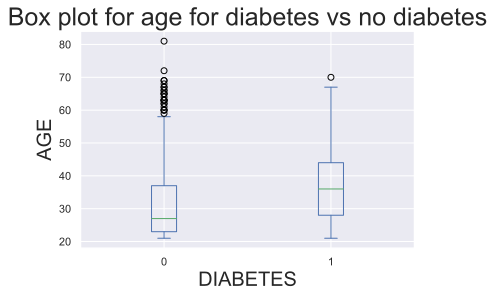

In [64]:
# Boxplot
age_boxplt = boxplt('AGE', 'Box plot for age for diabetes vs no diabetes')

In [65]:
# Outliers
age_outl = outliers(diabetes.AGE)
age_outl

Rango intercuartílico: 17.0
Lower and upper outlier limits: -1.5 ,  66.5
We have a total of 9 outliers


,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
123,5,132,80,0,0,26.8,0.186,69,0
363,4,146,78,0,0,38.5,0.520,67,1
453,2,119,0,0,0,19.6,0.832,72,0
459,9,134,74,33,60,25.9,0.460,81,0
489,8,194,80,0,0,26.1,0.551,67,0
537,0,57,60,0,0,21.7,0.735,67,0
666,4,145,82,18,0,32.5,0.235,70,1
674,8,91,82,0,0,35.6,0.587,68,0
684,5,136,82,0,0,0.0,0.640,69,0


**Conclusión de los outliers para AGE**

La variable `AGE` tiene un total de 9 outliers, que se situan poor encima del límite superior (66,5 años). 

Esta variable indica la edad de mujeres a partir de 21 años. Todos los outliers muestran edades mayores (69, 67, 72…) que son casos que se dan en la vida real, por lo que hemos decidido no eliminar los outliers.


### Eliminamos los outliers de las variables que hemos decidido
- GLUCOSE
- BLOODPRESS
- BODYMASSINDEX
- SKINTHICKNESS

In [66]:
# Eliminamos los outliers de GLUCOSE
drop_outliers(glucose_outl)

Outliers deleted.


In [67]:
# Eliminamos los outliers de BLOODPRESS
drop_outliers(bloodpress_outl)

Outliers deleted.


In [68]:
# Eliminamos los outliers de BODYMASSINDEX
drop_outliers(bodymassindex_outl)

Outliers deleted.


In [69]:
# Eliminamos los outliers de SKINTHICKNESS
drop_outliers(skinthickness_outl)

Outliers deleted.


In [70]:
diabetes.describe()

,PREGNANT,GLUCOSE,BLOODPRESS,SKINTHICKNESS,INSULIN,BODYMASSINDEX,PEDIGREEFUNC,AGE,DIABETES
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### STEP 4: ENCODE CATEGORICAL VARIABLES

There are no categorical input variables, but 'DIABETES' would be a categorical value. In this step we convert output variable to factor, in this case 'DIABETES' is as a categorical variable

In [34]:
diabetes.DIABETES = diabetes.DIABETES.astype('category') 
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PREGNANT       708 non-null    int64   
 1   GLUCOSE        708 non-null    int64   
 2   BLOODPRESS     708 non-null    int64   
 3   SKINTHICKNESS  708 non-null    int64   
 4   INSULIN        708 non-null    int64   
 5   BODYMASSINDEX  708 non-null    float64 
 6   PEDIGREEFUNC   708 non-null    float64 
 7   AGE            708 non-null    int64   
 8   DIABETES       708 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 50.6 KB


### STEP 5: EXPLORATORY ANALYSIS
In this step we get a correlation plot of numeric variables with 'pairplot'.

In [ ]:
# Scatterplot all vs all
sns.pairplot(diabetes, hue = 'DIABETES')
plt.show()

Elaboramos una matriz de correlación para detectar la correlación entre cada una de las variables, y la importancia de cada una de ellas en el dataset (cuanto más correlacionadas estén entre ellas, menos informacion aportarán a nuestro modelo).

En este caso, las variables que mayor correlación tienen son AGE y PREGNANT, con una correlación de 0.544. A esta cantidad de correlación entre dos variables se les considera moderada, por lo que siguen aportando información al análisis.

In [ ]:
### Exploratory analysis -------------------------------------------------------------------------------------
#correlation plot of numeric variables
#Lo que nos interesa es tener variables que sean muy diferentes entre ellas.
f = plt.figure()
plt.matshow(diabetes.select_dtypes(include=['int64','float64']).corr(), fignum=f.number)
plt.xticks(range(diabetes.select_dtypes(include=['int64','float64']).shape[1]), diabetes.select_dtypes(include=['int64','float64']).columns, fontsize=10, rotation=45)
plt.yticks(range(diabetes.select_dtypes(include=['int64','float64']).shape[1]), diabetes.select_dtypes(include=['int64','float64']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=20)
plt.show()

In [ ]:
np.corrcoef(diabetes.PREGNANT, diabetes.AGE)

### STEP 6: CHECK OUT FOR CLASS IMBALANCES

Como podemos ver, el datset se encuentra desbalanceado, ya que el 65% de los datos pertenecen a 0 en la variable DIABETES, y el 35% de los datos pertenecen al 1 en la variable DIABETES.

Como podemos ver, en la tabla de frecuencias de la variable salida hay muchos mas registros de la clase 0 que de la clase 1, en concreto, tenemos el 65% de los datos en la clase 0, y el 35% de los datos en la clase 1. Por lo que estamos ante unos datos desbalanceados.

Para balancear las clases, vamos a usar la librería **[imblearn](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)**, en concreto, el método de oversampling llamado SMOTE. Este método genera datos sintéticos de la clase minoritaria, para obtener muestras similares a nuestros datos y conseguir balancear las clases del dataset.

<img src='./fig/imblearn_example.png' style= 'width:300mm'>

In [ ]:
# Class count -- vemos que está desbalanceado
diabetes.DIABETES.value_counts()

In [ ]:
468+240

In [ ]:
# import library
from imblearn.over_sampling import SMOTE
smote = SMOTE()

x = diabetes.loc[:, diabetes.columns != 'DIABETES']
y = diabetes.DIABETES

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x, y)
print('Original dataset shape', len(y))
print('Resample dataset shape', len(y_smote))
diabetes_new = x_smote
diabetes_new['DIABETES']=y_smote

# Comprobamos que las métricas de las variables numéricas se mantienen 
#aproximadamente similares tras el oversampling

In [ ]:
# Class count -- vemos que está desbalanceado
diabetes_new.DIABETES.value_counts()

In [ ]:
468*2

In [ ]:
diabetes.DIABETES.value_counts()

In [ ]:
480+240

Comprovamos que los datos siguen balanceados despues de eliminar los outliers.

Como podemos ver, al balancear los datos se han añadido valores en la clase 1 de la variable DIABETES, de esta forma, teniendo oun 50% de los datos en 0 y un 50% de los datos en 1

Una vez eliminados los outliers, balanceados los datos, detectada la correlación entre las variables, y la importancia que tienen para el dataset, comprobamos cómo han cambiado las métricas de las variables antes y después de balancear los datos.

In [ ]:
diabetes.describe()

In [ ]:
diabetes_new.describe()

Aquí tenemos las métricas de las output variables antes y después de balancear los datos.

La principal diferencia es la cantidad de observaciones de las variables. Antes de balancear los datos teníamos un total de 720 variables (468 para 0 y 240 para 1), y después de balancearlos tenemos un total de 936 variables (468 para 0 y 468 para 1).

En cuanto al resto de las métricas apenas han  variado, a excepción del mínimo y el máximo que se mantienen en todas las variables. Con esto podemos concluir que el dataset ha variado muy poco.

### STEP 7: Split the `dataset ` into train and test 

In [ ]:
# Define input and output matrices
INPUTS = ['PREGNANT','GLUCOSE','BLOODPRESS','SKINTHICKNESS','INSULIN','BODYMASSINDEX','PEDIGREEFUNC','AGE']
OUTPUT = 'DIABETES'
X = diabetes[INPUTS]
y = diabetes[OUTPUT]

X_new = diabetes_new[INPUTS]
y_new = diabetes_new[OUTPUT]

# Split original dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data 20%
                                                    random_state=0, #seed for replication, es para que me salga la =
                                                    stratify = y)   #Preserves distribution of y

# Split  modificated dataset
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new,
                                                    test_size=0.2,  #percentage of test data 20%
                                                    random_state=0, #seed for replication, es para que me salga la =
                                                    stratify = y_new)   #Preserves distribution of y

In [ ]:
## Create dataset to store model predictions for original dataset
dfTR_eval = X_train.copy()
dfTR_eval['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test # We will call Y as output variable for simplicity>

In [ ]:
## Create dataset to store model predictions for modificated dataset
dfTR_eval_new = X_train_new.copy()
dfTR_eval_new['Y'] = y_train_new # We will call Y as output variable for simplicity
dfTS_eval_new = X_test_new.copy()
dfTS_eval_new['Y'] = y_test_new # We will call Y as output variable for simplicity>

## 2. Training of Machine Learning models

Vamos a comenzar generando un árbol de decisión, para que nos detecte las variables más significativas de nuestro modelo y podamos hacer pruebas con varias de ellas.

Para este paso, vamos a hacer pruebas con los dos datasets que tenemos:
+ El dataset original, con todos los datos con outliers y desbalanceo de clases
+ El dataset preparado, sin outliers y con clases balanceadas

 ### 2.1.- Decision Trees

- [DecisionTreeClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree)

 ### 2.1.1- `TEST WITH THE ORIGINAL DATASET`

In [ ]:
#-------------------------------------------------------------------------------------------------
#---------------------------- DECISION TREE MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection

INPUTS_DT = INPUTS

param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split. Valor que vamos a usar para la validación cruzada. Los porcentajes de mejora varían en funcion del problema
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting. minimo numero de muestras en un split
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node. minimo numero de muestras en un nodo terminal.
                                                     random_state=200))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10

# el arbol lo vamos a obtener mediante grid search
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid


**FALTA INDICAR EL POR QUÉ DE LOS PARÁMETROS**

In [ ]:
## Plot the decision tree model
plt.figure(figsize=(12, 12))
plot_tree(tree_fit.best_estimator_['DT'], filled=True)
plt.show()

In [ ]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train[INPUTS_DT].columns))
bar_width = 0.35
plt.bar(index, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train[INPUTS_DT].columns)
plt.tight_layout()
plt.show()

In [ ]:
##  Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_DT_pred'] = tree_fit.predict(X_train[INPUTS_DT])
dfTR_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,0]
dfTR_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,1]

### Scale test using preprocess in training
dfTS_eval['Y_DT_pred'] = tree_fit.predict(X_test[INPUTS_DT])
dfTS_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_test[INPUTS_DT])[:,0]
dfTS_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_test[INPUTS_DT])[:,1]

#visualize evaluated data
dfTR_eval.head()

In [ ]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_DT_pred'], labels=[0,1])

In [ ]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_DT_pred'], labels=[0,1])

In [ ]:

CT.plotClassPerformance(dfTS_eval['Y'], tree_fit.predict_proba(X_test[INPUTS_DT]), selClass=1)

**TO DO** COMENTAR LOS RESULTADOS DE ESTO

 ### 2.1.1- `TEST WITH MODIFICATED DATASET`

In [ ]:
#-------------------------------------------------------------------------------------------------
#---------------------------- DECISION TREE MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection

INPUTS_DT = INPUTS

param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split. Valor que vamos a usar para la validación cruzada. Los porcentajes de mejora varían en funcion del problema
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting. minimo numero de muestras en un split
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node. minimo numero de muestras en un nodo terminal.
                                                     random_state=200))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10

# el arbol lo vamos a obtener mediante grid search
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 

tree_fit.fit(X_train_new[INPUTS_DT], y_train_new) # Search in grid

In [ ]:
## Plot the decision tree model
plt.figure(figsize=(12, 12))
plot_tree(tree_fit.best_estimator_['DT'], filled=True)
plt.show()

In [ ]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train_new[INPUTS_DT].columns))
bar_width = 0.35
plt.bar(index, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train_new[INPUTS_DT].columns)
plt.tight_layout()
plt.show()

In [ ]:
##  Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval_new['Y_DT_pred'] = tree_fit.predict(X_train_new[INPUTS_DT])
dfTR_eval_new['Y_DT_prob_neg'] = tree_fit.predict_proba(X_train_new[INPUTS_DT])[:,0]
dfTR_eval_new['Y_DT_prob_pos'] = tree_fit.predict_proba(X_train_new[INPUTS_DT])[:,1]

### Scale test using preprocess in training
dfTS_eval_new['Y_DT_pred'] = tree_fit.predict(X_test_new[INPUTS_DT])
dfTS_eval_new['Y_DT_prob_neg'] = tree_fit.predict_proba(X_test_new[INPUTS_DT])[:,0]
dfTS_eval_new['Y_DT_prob_pos'] = tree_fit.predict_proba(X_test_new[INPUTS_DT])[:,1]

#visualize evaluated data
dfTR_eval_new.head()

In [ ]:
CT.confusion_matrix(dfTR_eval_new['Y'], dfTR_eval_new['Y_DT_pred'], labels=[0,1])

In [ ]:
CT.confusion_matrix(dfTS_eval_new['Y'], dfTS_eval_new['Y_DT_pred'], labels=[0,1])

In [ ]:
CT.plotClassPerformance(dfTS_eval_new['Y'], tree_fit.predict_proba(X_test_new[INPUTS_DT]), selClass=1)

**TO DO**: Comentar resultados


### 2.1 Random Forest 

- [RandomForestClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [Wikipedia](https://en.wikipedia.org/wiki/Random_forest)

 ### 3.1.1- `TEST WITH ORIGINAL DATASET`

In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS = ['PREGNANT','GLUCOSE','BLOODPRESS','SKINTHICKNESS','INSULIN','BODYMASSINDEX','PEDIGREEFUNC','AGE']
INPUTS_RF = INPUTS

param = {'RF__n_estimators': range(10, 200, 10)} #Number of trees to grow
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('RF', RandomForestClassifier(criterion='gini', # impuriry measure
                                                  max_features=len(X_train.columns),  # number of variables randomly sampled as candidates at each split.
                                                  min_samples_split=5,  # Minimum number of obs in node to keep cutting
                                                  min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                  random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
rf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
rf_fit.fit(X_train[INPUTS_RF], y_train) # Search in grid

In [ ]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train[INPUTS_RF].columns))
bar_width = 0.35
plt.bar(index, rf_fit.best_estimator_['RF'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train.columns)
plt.tight_layout()
plt.show()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_RF_pred'] = rf_fit.predict(X_train[INPUTS_RF])
dfTR_eval['Y_RF_prob_neg'] = rf_fit.predict_proba(X_train[INPUTS_RF])[:,0]
dfTR_eval['Y_RF_prob_pos'] = rf_fit.predict_proba(X_train[INPUTS_RF])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_RF_pred'] = rf_fit.predict(X_test[INPUTS_RF])
dfTS_eval['Y_RF_prob_neg'] = rf_fit.predict_proba(X_test[INPUTS_RF])[:,0]
dfTS_eval['Y_RF_prob_pos'] = rf_fit.predict_proba(X_test[INPUTS_RF])[:,1]
dfTR_eval.head()

In [ ]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_RF_pred'])

In [ ]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_RF_pred'])

In [ ]:
CT.plotClassPerformance(dfTS_eval['Y'], rf_fit.predict_proba(X_test[INPUTS_RF]), selClass=1)

 ### 3.1.1- `TEST WITH MODIFICATED DATASET`

In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_RF = INPUTS

param = {'RF__n_estimators': range(10, 200, 10)} #Number of trees to grow
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('RF', RandomForestClassifier(criterion='gini', # impuriry measure
                                                  max_features=len(X_train_new.columns),  # number of variables randomly sampled as candidates at each split.
                                                  min_samples_split=5,  # Minimum number of obs in node to keep cutting
                                                  min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                  random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
rf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
rf_fit.fit(X_train_new[INPUTS_RF], y_train_new) # Search in grid

In [ ]:
## Plot the variable importance of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train_new[INPUTS_RF].columns))
bar_width = 0.35
plt.bar(index, rf_fit.best_estimator_['RF'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train_new.columns)
plt.tight_layout()
plt.show()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval_new['Y_RF_pred'] = rf_fit.predict(X_train_new[INPUTS_RF])
dfTR_eval_new['Y_RF_prob_neg'] = rf_fit.predict_proba(X_train_new[INPUTS_RF])[:,0]
dfTR_eval_new['Y_RF_prob_pos'] = rf_fit.predict_proba(X_train_new[INPUTS_RF])[:,1]
### Scale test using preprocess in training
dfTS_eval_new['Y_RF_pred'] = rf_fit.predict(X_test_new[INPUTS_RF])
dfTS_eval_new['Y_RF_prob_neg'] = rf_fit.predict_proba(X_test_new[INPUTS_RF])[:,0]
dfTS_eval_new['Y_RF_prob_pos'] = rf_fit.predict_proba(X_test_new[INPUTS_RF])[:,1]

In [ ]:
CT.confusion_matrix(dfTR_eval_new['Y'], dfTR_eval_new['Y_RF_pred'])

In [ ]:
CT.confusion_matrix(dfTS_eval_new['Y'], dfTS_eval_new['Y_RF_pred'])

In [ ]:
CT.plotClassPerformance(dfTS_eval_new['Y'], rf_fit.predict_proba(X_test_new[INPUTS_RF]), selClass=1)

### 3.1 Logistic Regression

- [LogisticRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression)

In [ ]:
diabetes.shape ##EL ORIGINAL ES EL ORIGINAL

 ### 3.1.1- `TEST WITH ORIGINAL DATASET`

In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR = INPUTS

#ModLogReg = LogisticRegression()
LogReg_fit = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model 
                        ('LogReg',LogisticRegression(random_state=5))]) # Model to use in the pipeline

#Es como una tuberia, lo primero que va a hacer es un 'scaler' es una funcion que me escala las variables
#Lo que hace es normalizarlo, le quita la media y lo divide entre la varianza

#Train model
LogReg_fit.fit(X_train[INPUTS_LR], y_train);

print("Logistic Regression Trained")

In [ ]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=10, scoring='accuracy').mean()

In [ ]:
#El p-valor es la ultima columna
CT.summaryLogReg(LogReg_fit, X_train[INPUTS_LR], y_train) #Esto te da los resultados de los que hablabamos en casa

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_pred'] = LogReg_fit.predict(X_train[INPUTS_LR])
dfTR_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,0] #NO 
dfTR_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,1] #YES
### Scale test using preprocess in training ---------------------------------------------
dfTS_eval['Y_LR_pred'] = LogReg_fit.predict(X_test)
dfTS_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,0]
dfTS_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,1]

In [ ]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_LR_pred'], labels=[0,1])

In [ ]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_LR_pred'], labels=[0,1])

In [ ]:
CT.plotClassPerformance(dfTR_eval['Y'], LogReg_fit.predict_proba(X_train[INPUTS_LR]), selClass=1)

#### LO QUE HE HECHO ES DEJAR SOLO LAS QUE SON MAS SIGNIFICANTES EN EL MODELO, PERO EL RESULTADO NO ES MUY BUENO
+ Lo que he hecho ha sido quitar las que no son importantes en el modelo anterior, que siguen mas o menos la misma dinamica que otros modelos

In [ ]:
# Define input and output matrices
INPUTS = ['PREGNANT','GLUCOSE','BLOODPRESS','BODYMASSINDEX','PEDIGREEFUNC','AGE']
OUTPUT = 'DIABETES'

X = diabetes[INPUTS]
y = diabetes[OUTPUT]

# Split original dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data 20%
                                                    random_state=0, #seed for replication, es para que me salga la =
                                                    stratify = y)   #Preserves distribution of y

In [ ]:
## Create dataset to store model predictions for original dataset
dfTR_eval = X_train.copy()
dfTR_eval['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test # We will call Y as output variable for simplicity>

In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR = INPUTS

#ModLogReg = LogisticRegression()
LogReg_fit = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model 
                        ('LogReg',LogisticRegression(random_state=5))]) # Model to use in the pipeline

#Es como una tuberia, lo primero que va a hacer es un 'scaler' es una funcion que me escala las variables
#Lo que hace es normalizarlo, le quita la media y lo divide entre la varianza

#Train model
LogReg_fit.fit(X_train[INPUTS_LR], y_train);

print("Logistic Regression Trained")

In [ ]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=10, scoring='accuracy').mean()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_pred'] = LogReg_fit.predict(X_train[INPUTS_LR])
dfTR_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,0] #NO 
dfTR_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,1] #YES
### Scale test using preprocess in training ---------------------------------------------
dfTS_eval['Y_LR_pred'] = LogReg_fit.predict(X_test)
dfTS_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,0]
dfTS_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,1]

In [ ]:
CT.summaryLogReg(LogReg_fit, X_train[INPUTS_LR], y_train) #Esto te da los resultados de los que hablabamos en casa

In [ ]:
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_LR_pred'], labels=[0,1])

In [ ]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_LR_pred'], labels=[0,1])

In [ ]:
CT.plotClassPerformance(dfTR_eval['Y'], LogReg_fit.predict_proba(X_train[INPUTS_LR]), selClass=1)

 ### 3.1.1- `TEST WITH MODIFICATED DATASET`

In [ ]:
diabetes_new.shape #GENIAL

In [ ]:
INPUTS = ['PREGNANT','GLUCOSE','BLOODPRESS','SKINTHICKNESS','INSULIN','BODYMASSINDEX','PEDIGREEFUNC','AGE']
OUTPUT = 'DIABETES'

X_new = diabetes_new[INPUTS]
y_new = diabetes_new[OUTPUT]


X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new,
                                                    test_size=0.2,  #percentage of test data 20%
                                                    random_state=0, #seed for replication, es para que me salga la =
                                                    stratify = y_new)   #Preserves distribution of y

In [ ]:
## Create dataset to store model predictions for modificated dataset
dfTR_eval_new = X_train_new.copy()
dfTR_eval_new['Y'] = y_train_new # We will call Y as output variable for simplicity
dfTS_eval_new = X_test_new.copy()
dfTS_eval_new['Y'] = y_test_new # We will call Y as output variable for simplicity

In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR = INPUTS

#ModLogReg = LogisticRegression()
LogReg_fit = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model 
                        ('LogReg',LogisticRegression(random_state=5))]) # Model to use in the pipeline

LogReg_fit.fit(X_train_new[INPUTS_LR], y_train_new);

print("Logistic Regression Trained")

In [ ]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit, X_train_new[INPUTS_LR], y_train_new, cv=10, scoring='accuracy').mean()

In [ ]:
CT.summaryLogReg(LogReg_fit, X_train_new[INPUTS_LR], y_train_new) #Esto te da los resultados de los que hablabamos en casa

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval_new['Y_LR_pred'] = LogReg_fit.predict(X_train_new[INPUTS_LR])
dfTR_eval_new['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_train_new[INPUTS_LR])[:,0] #NO 
dfTR_eval_new['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_train_new[INPUTS_LR])[:,1] #YES
### Scale test using preprocess in training ---------------------------------------------
dfTS_eval_new['Y_LR_pred'] = LogReg_fit.predict(X_test_new)
dfTS_eval_new['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_test_new[INPUTS_LR])[:,0]
dfTS_eval_new['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_test_new[INPUTS_LR])[:,1]

In [ ]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval_new['Y'], dfTR_eval_new['Y_LR_pred'], labels=[0,1])

In [ ]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval_new['Y'], dfTS_eval_new['Y_LR_pred'], labels=[0,1])

In [ ]:
CT.plotClassPerformance(dfTR_eval_new['Y'], LogReg_fit.predict_proba(X_train_new[INPUTS_LR]), selClass=1)

# ESTE ULTIMO HA MEJORADO RESPECTO A LOS OTROS DOS, VOY A PROBARLO QUITANDOLE UNAS VARIABLES QUE NO SON RELEVANTES

In [ ]:
#INPUTS = ['GLUCOSE','BODYMASSINDEX','PEDIGREEFUNC','AGE']
INPUTS = ['GLUCOSE','BLOODPRESS','BODYMASSINDEX','PEDIGREEFUNC','AGE']

OUTPUT = 'DIABETES'

X_new = diabetes_new[INPUTS]
y_new = diabetes_new[OUTPUT]


X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new,
                                                    test_size=0.2,  #percentage of test data 20%
                                                    random_state=0, #seed for replication, es para que me salga la =
                                                    stratify = y_new)   #Preserves distribution of y

In [ ]:
## Create dataset to store model predictions for modificated dataset
dfTR_eval_new = X_train_new.copy()
dfTR_eval_new['Y'] = y_train_new # We will call Y as output variable for simplicity
dfTS_eval_new = X_test_new.copy()
dfTS_eval_new['Y'] = y_test_new # We will call Y as output variable for simplicity>

In [ ]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR = INPUTS

#ModLogReg = LogisticRegression()
LogReg_fit = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model 
                        ('LogReg',LogisticRegression(random_state=5))]) # Model to use in the pipeline

#Es como una tuberia, lo primero que va a hacer es un 'scaler' es una funcion que me escala las variables
#Lo que hace es normalizarlo, le quita la media y lo divide entre la varianza

#Train model
LogReg_fit.fit(X_train_new[INPUTS_LR], y_train_new);

print("Logistic Regression Trained")

In [ ]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(LogReg_fit, X_train_new[INPUTS_LR], y_train_new, cv=10, scoring='accuracy').mean()

In [ ]:
CT.summaryLogReg(LogReg_fit, X_train_new[INPUTS_LR], y_train_new) #Esto te da los resultados de los que hablabamos en casa

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval_new['Y_LR_pred'] = LogReg_fit.predict(X_train_new[INPUTS_LR])
dfTR_eval_new['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_train_new[INPUTS_LR])[:,0] #NO 
dfTR_eval_new['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_train_new[INPUTS_LR])[:,1] #YES
### Scale test using preprocess in training ---------------------------------------------
dfTS_eval_new['Y_LR_pred'] = LogReg_fit.predict(X_test_new)
dfTS_eval_new['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_test_new[INPUTS_LR])[:,0]
dfTS_eval_new['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_test_new[INPUTS_LR])[:,1]

In [ ]:
#Confusion matrix for Log Reg Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval_new['Y'], dfTR_eval_new['Y_LR_pred'], labels=[0,1])

In [ ]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval_new['Y'], dfTS_eval_new['Y_LR_pred'], labels=[0,1])

In [ ]:
CT.plotClassPerformance(dfTR_eval_new['Y'], LogReg_fit.predict_proba(X_train_new[INPUTS_LR]), selClass=1)

### Support Vector Machines (SVM)

- [SVC()](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc)
- [Wikipedia](https://en.wikipedia.org/wiki/Support-vector_machine)

Vamos a probar diferentes tipos de svm
+ LINEAL
+ POLINOMIAL
+ RADIAL

Los kernels Polinomial y Radial se utilizan cuando las clases no son linealmente separables, como hemos visto al pintar las gráficas de distribución de los datos, no lo son, por lo tanto usaremos estos dos tipos de kernels

Para diferentes datasets
+ Original
+ Limpio
+ Limpio con variables más significativas (segín el Random Forest)

#### En primer lugar probamos con el dataset completo

In [ ]:
# Define input and output matrices
INPUTS = ['PREGNANT','GLUCOSE','BLOODPRESS','SKINTHICKNESS','INSULIN','BODYMASSINDEX','PEDIGREEFUNC','AGE']
OUTPUT = 'DIABETES'
X = diabetes[INPUTS]
y = diabetes[OUTPUT]

# Split original dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data 20%
                                                    random_state=0, #seed for replication, es para que me salga la =
                                                    stratify = y)   #Preserves distribution of y

In [ ]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test # We will call Y as output variable for simplicity

In [ ]:
#-------------------------------------------------------------------------------------------------
#------------------------------- LINEAR SVM MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LSVC = INPUTS

param = {'SVC__C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]} # Cost term
pipe = Pipeline(steps=[ ('scaler', StandardScaler()), 
                        ('SVC',  SVC(kernel='linear', # lineal kernel
                                    probability=True, # let the model predict probabilities
                                    random_state=150))]) # For replication


# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 5
Linear_SVC_gcv = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 
Linear_SVC_gcv.fit(X_train[INPUTS_LSVC], y_train) # Search in grid

# We use Calibrated CV to transform predictions of the model to probabilities due to a known bug in scikit SVC
Linear_SVC_fit = CalibratedClassifierCV(
                        base_estimator=Linear_SVC_gcv, # Structure of the model to use
                        n_jobs=-1, # Number of cores to use (parallelize)
                        method='isotonic', # The method to use for calibration
                        cv=nFolds) # Number of Folds 
Linear_SVC_fit.fit(X_train[INPUTS_LSVC], y_train) # Search in grid

In [ ]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(Linear_SVC_fit, X_train[INPUTS_LSVC], y_train, cv=10, scoring='accuracy').mean()

In [ ]:
## Plot the variable coefficient of each feature
plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(X_train[INPUTS_LSVC].columns))
bar_width = 0.35
plt.bar(index, Linear_SVC_fit.base_estimator.best_estimator_['SVC'].coef_[0,:], color='black', alpha=0.5)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Coefficients of features')
plt.xticks(index, X_train[INPUTS_LSVC].columns)
plt.tight_layout()
plt.show()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LSVC_pred'] = Linear_SVC_fit.predict(X_train[INPUTS_LSVC])
dfTR_eval['Y_LSVC_prob_neg'] = Linear_SVC_fit.predict_proba(X_train[INPUTS_LSVC])[:,0]
dfTR_eval['Y_LSVC_prob_pos'] = Linear_SVC_fit.predict_proba(X_train[INPUTS_LSVC])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LSVC_pred'] = Linear_SVC_fit.predict(X_test[INPUTS_LSVC])
dfTS_eval['Y_LSVC_prob_neg'] = Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC])[:,0]
dfTS_eval['Y_LSVC_prob_pos'] = Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC])[:,1]

#visualize evaluated data
dfTR_eval.head()

In [ ]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_LSVC_pred'], labels=[0,1])

In [ ]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_LSVC_pred'], labels=[0,1])

In [ ]:
CT.plotClassPerformance(dfTS_eval['Y'], Linear_SVC_fit.predict_proba(X_test[INPUTS_LSVC]), selClass=1)

In [ ]:
#-------------------------------------------------------------------------------------------------
#------------------------------- POLYNOMIAL SVM MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_PSVC = INPUTS
## Train model -----------------------------------------------------------------------------------
param = {'SVC__C': [0.001,0.01,0.1,1,10], # Cost term
         'SVC__gamma':[0.0001,0.001,0.01,0.1,1]} # Inverse width parameter in the Gaussian Radial Basis kernel 

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('SVC', SVC(kernel='poly', # polynomial kernel
                                   degree=8,# funcion polinomial cuadratica
                                   probability=True, # let the model predict probabilities
                                   random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 5
PSVC_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
PSVC_fit.fit(X_train[INPUTS_PSVC], y_train) # Search in grid

In [ ]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(PSVC_fit, X_train[INPUTS_PSVC], y_train, cv=10, scoring='accuracy').mean()

In [ ]:
MT.plotModelGridError(PSVC_fit, xscale="log", xscale2='log')

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_PSVC_pred'] = PSVC_fit.predict(X_train[INPUTS_PSVC])
dfTR_eval['Y_PSVC_prob_neg'] = PSVC_fit.predict_proba(X_train[INPUTS_PSVC])[:,0]
dfTR_eval['Y_PSVC_prob_pos'] = PSVC_fit.predict_proba(X_train[INPUTS_PSVC])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_PSVC_pred'] = PSVC_fit.predict(X_test[INPUTS_PSVC])
dfTS_eval['Y_PSVC_prob_neg'] = PSVC_fit.predict_proba(X_test[INPUTS_PSVC])[:,0]
dfTS_eval['Y_PSVC_prob_pos'] = PSVC_fit.predict_proba(X_test[INPUTS_PSVC])[:,1]

#visualize evaluated data
dfTR_eval.head()

In [ ]:
#Confusion matrix for SVC Linear Model
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_PSVC_pred'], labels=[0,1])

In [ ]:
#Es muy importante comparar el train como el test, ya donde tienen que ser lo mas similares posibles
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_PSVC_pred'], labels=[0,1])

In [ ]:
CT.plotClassPerformance(dfTS_eval['Y'], PSVC_fit.predict_proba(X_test[INPUTS_PSVC]), selClass=1)

#### Ahora, probamos con el mismo dataset pero con el kernel radial


In [ ]:
#-------------------------------------------------------------------------------------------------
#------------------------------- RADIAL SVM MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
# mismo dataset que antes, pero con kernel radial
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_RSVC = INPUTS
## Train model -----------------------------------------------------------------------------------
param = {'SVC__C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000], # Cost term
         'SVC__gamma':[0.0001,0.001,0.01,0.1,1,10]} # Inverse width parameter in the Gaussian Radial Basis kernel 
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('SVC', SVC(kernel='rbf', # gausian kernel
                                   probability=True, # let the model predict probabilities
                                   random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
SVC_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
SVC_fit.fit(X_train[INPUTS_RSVC], y_train) # Search in grid

In [ ]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(SVC_fit, X_train[INPUTS_RSVC], y_train, cv=10, scoring='accuracy').mean()

In [ ]:
MT.plotModelGridError(SVC_fit, xscale="log", xscale2='log')

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_SVC_pred'] = SVC_fit.predict(X_train[INPUTS_RSVC])
dfTR_eval['Y_SVC_prob_neg'] = SVC_fit.predict_proba(X_train[INPUTS_RSVC])[:,0]
dfTR_eval['Y_SVC_prob_pos'] = SVC_fit.predict_proba(X_train[INPUTS_RSVC])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_SVC_pred'] = SVC_fit.predict(X_test[INPUTS_RSVC])
dfTS_eval['Y_SVC_prob_neg'] = SVC_fit.predict_proba(X_test[INPUTS_RSVC])[:,0]
dfTS_eval['Y_SVC_prob_pos'] = SVC_fit.predict_proba(X_test[INPUTS_RSVC])[:,1]

dfTR_eval.head()

In [ ]:
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_SVC_pred'], labels=[0,1])

In [ ]:
print("----- TEST CONFUSION MATRIX -----")
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_SVC_pred'], labels=[0,1])

Entre ambos modelos, entrenados con el mismo dataset, y configurados con los mismos parámetros, podemos ver que a penas hay diferencia. El accuracy de test en el modelo lineal nos sale `0.78`, mientras que en el modelo radial nos sale `0.78`.  

Vamos a entrenar los mismos modelos ahora, solo que esta vez con un dataset diferente. Usaremos el dataset limpio, sin outliers y con las clases balanceadas, para comprobar si el modelo mejora.

In [ ]:
# Define input and output matrices
INPUTS = ['PREGNANT','GLUCOSE','BLOODPRESS','SKINTHICKNESS','INSULIN','BODYMASSINDEX','PEDIGREEFUNC','AGE']
OUTPUT = 'DIABETES'

X_new = diabetes_new[INPUTS]
y_new = diabetes_new[OUTPUT]

# Split  modificated dataset
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new,
                                                    test_size=0.2,  #percentage of test data 20%
                                                    random_state=0, #seed for replication, es para que me salga la =
                                                    stratify = y_new)   #Preserves distribution of y

## Create dataset to store model predictions for modificated dataset
dfTR_eval_new = X_train_new.copy()
dfTR_eval_new['Y'] = y_train_new # We will call Y as output variable for simplicity
dfTS_eval_new = X_test_new.copy()
dfTS_eval_new['Y'] = y_test_new # We will call Y as output variable for simplicity

In [ ]:
#-------------------------------------------------------------------------------------------------
#------------------------------- LINEAR SVM MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LSVC = INPUTS

param = {'SVC__C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]} # Cost term
pipe = Pipeline(steps=[ ('scaler', StandardScaler()), 
                        ('SVC',  SVC(kernel='linear', # lineal kernel
                                    probability=True, # let the model predict probabilities
                                    random_state=150))]) # For replication


# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 5
Linear_SVC_gcv = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize)
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                        cv=nFolds) # Number of Folds 
Linear_SVC_gcv.fit(X_train[INPUTS_LSVC], y_train) # Search in grid

# We use Calibrated CV to transform predictions of the model to probabilities due to a known bug in scikit SVC
Linear_SVC_fit = CalibratedClassifierCV(
                        base_estimator=Linear_SVC_gcv, # Structure of the model to use
                        n_jobs=-1, # Number of cores to use (parallelize)
                        method='isotonic', # The method to use for calibration
                        cv=nFolds) # Number of Folds 
Linear_SVC_fit.fit(X_train[INPUTS_LSVC], y_train) # Search in grid

### 3.2. K-Nearest Neighbours

 ### 3.2.1- `TEST WITH ORIGINAL DATASET`

In [ ]:
INPUTS = ['PREGNANT','GLUCOSE','BLOODPRESS','SKINTHICKNESS','INSULIN','BODYMASSINDEX','PEDIGREEFUNC','AGE']
#OUTPUT = 'DIABETES'
INPUTS_KNN = INPUTS

## Configure model and hyparameter tuning
param = {'knn__n_neighbors': range(3,135,4)} #Number of neighbors
# te permite configurar los hiperparámetros, en este caso hace un barrido desde 3 hasta 135 vecinos de 4 en 4
#param = {'knn__n_neighbors': [60]} # Uncomment in case only one parameter is wanted
# en este incluimos solo k=60

# Scale data previous to fit
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10 
knn_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize) - por defecto lo dejamos asi
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html - metrica en la validacion que queremos que maximice
                        cv=nFolds) # Number of Folds - numero de particiones en cross validation K=10 (diapo 24)
# en un rango de valores, va a buscar el mejor valor en una metrica en validacion cruzada 

# Search in grid and train model --------------------
knn_fit.fit(X_train[INPUTS_KNN], y_train) 

print("kNN Trained")

In [ ]:
MT.plotModelGridError(knn_fit)

In [ ]:
knn_fit.cv_results_

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_knn_pred'] = knn_fit.predict(X_train[INPUTS_KNN])
dfTR_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,0]
dfTR_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_knn_pred'] = knn_fit.predict(X_test[INPUTS_KNN])
dfTS_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,0]
dfTS_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,1]

In [ ]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_knn_pred'])

In [ ]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_knn_pred'])

In [ ]:
CT.plotClassPerformance(dfTR_eval['Y'], knn_fit.predict_proba(X_train[INPUTS_KNN]), selClass=1)

 ### 3.2.2- `TEST WITH MODIFICATED DATASET`

In [ ]:
#---------- KNN MODEL ------------------

## Inputs of the model. Change accordingly to
INPUTS = ['PREGNANT','GLUCOSE','BLOODPRESS','SKINTHICKNESS','INSULIN','BODYMASSINDEX','PEDIGREEFUNC','AGE']
INPUTS_KNN = INPUTS

## Configure model and hyparameter tuning
param = {'knn__n_neighbors': range(3,135,4)} #Number of neighbors
# te permite configurar los hiperparámetros, en este caso hace un barrido desde 3 hasta 135 vecinos de 4 en 4
#param = {'knn__n_neighbors': [60]} # Uncomment in case only one parameter is wanted
# en este incluimos solo k=60

# Scale data previous to fit
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10 
knn_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize) - por defecto lo dejamos asi
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html - metrica en la validacion que queremos que maximice
                        cv=nFolds) # Number of Folds - numero de particiones en cross validation K=10 (diapo 24)
# en un rango de valores, va a buscar el mejor valor en una metrica en validacion cruzada 

# Search in grid and train model --------------------
knn_fit.fit(X_train_new[INPUTS_KNN], y_train_new) 

print("kNN Trained")

In [ ]:
MT.plotModelGridError(knn_fit)

In [ ]:
knn_fit.cv_results_

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval_new['Y_knn_pred'] = knn_fit.predict(X_train_new[INPUTS_KNN])
dfTR_eval_new['Y_knn_prob_neg'] = knn_fit.predict_proba(X_train_new[INPUTS_KNN])[:,0]
dfTR_eval_new['Y_knn_prob_pos'] = knn_fit.predict_proba(X_train_new[INPUTS_KNN])[:,1]
### Scale test using preprocess in training
dfTS_eval_new['Y_knn_pred'] = knn_fit.predict(X_test_new[INPUTS_KNN])
dfTS_eval_new['Y_knn_prob_neg'] = knn_fit.predict_proba(X_test_new[INPUTS_KNN])[:,0]
dfTS_eval_new['Y_knn_prob_pos'] = knn_fit.predict_proba(X_test_new[INPUTS_KNN])[:,1]

In [ ]:
CT.confusion_matrix(dfTR_eval_new['Y'], dfTR_eval_new['Y_knn_pred'])

In [ ]:
CT.confusion_matrix(dfTS_eval_new['Y'], dfTS_eval_new['Y_knn_pred'])

In [ ]:
CT.plotClassPerformance(dfTR_eval_new['Y'], knn_fit.predict_proba(X_train_new[INPUTS_KNN]), selClass=1)

# PROBAMOS CON LAS VARIABLES MÁS SIGNIFICATIVAS SIN LOS OUTLIERS

In [ ]:
#---------- KNN MODEL ------------------

## Inputs of the model. Change accordingly to
# PONER TODOS LOS INPUTS PARA ESTE, CAMBIARLO
INPUTS = ['GLUCOSE', 'PEDIGREEFUNC', 'BODYMASSINDEX', 'AGE']
INPUTS_KNN = INPUTS

## Configure model and hyparameter tuning
param = {'knn__n_neighbors': range(3,135,4)} #Number of neighbors
# te permite configurar los hiperparámetros, en este caso hace un barrido desde 3 hasta 135 vecinos de 4 en 4
#param = {'knn__n_neighbors': [60]} # Uncomment in case only one parameter is wanted
# en este incluimos solo k=60

# Scale data previous to fit
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10 
knn_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                        param_grid=param, # Defined grid to search in
                        n_jobs=-1, # Number of cores to use (parallelize) - por defecto lo dejamos asi
                        scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html - metrica en la validacion que queremos que maximice
                        cv=nFolds) # Number of Folds - numero de particiones en cross validation K=10 (diapo 24)
# en un rango de valores, va a buscar el mejor valor en una metrica en validacion cruzada 

# Search in grid and train model --------------------
knn_fit.fit(X_train_new[INPUTS_KNN], y_train_new) 

print("kNN Trained")

In [ ]:
MT.plotModelGridError(knn_fit)

In [ ]:
knn_fit.cv_results_

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval_new['Y_knn_pred'] = knn_fit.predict(X_train_new[INPUTS_KNN])
dfTR_eval_new['Y_knn_prob_neg'] = knn_fit.predict_proba(X_train_new[INPUTS_KNN])[:,0]
dfTR_eval_new['Y_knn_prob_pos'] = knn_fit.predict_proba(X_train_new[INPUTS_KNN])[:,1]
### Scale test using preprocess in training
dfTS_eval_new['Y_knn_pred'] = knn_fit.predict(X_test_new[INPUTS_KNN])
dfTS_eval_new['Y_knn_prob_neg'] = knn_fit.predict_proba(X_test_new[INPUTS_KNN])[:,0]
dfTS_eval_new['Y_knn_prob_pos'] = knn_fit.predict_proba(X_test_new[INPUTS_KNN])[:,1]

In [ ]:
CT.confusion_matrix(dfTR_eval_new['Y'], dfTR_eval_new['Y_knn_pred'])

In [ ]:
CT.confusion_matrix(dfTS_eval_new['Y'], dfTS_eval_new['Y_knn_pred'])

In [ ]:
CT.plotClassPerformance(dfTR_eval_new['Y'], knn_fit.predict_proba(X_train_new[INPUTS_KNN]), selClass=1)

---
# Compare models
#### Podemos comparar todos los modelos utilizados, segun el dataset, para ver cuáles de ellos y con qué datos nos dan mejores resultados

In [ ]:
## Compare models
metric = 'Accuracy'
score = {'Linear SVC': cross_val_score(Linear_SVC_fit, X_train[INPUTS_LSVC], y_train, cv=10, scoring='accuracy'), 
         'Polynomial(2) SVC': cross_val_score(PSVC_fit, X_train[INPUTS_PSVC], y_train, cv=5, scoring='accuracy'), 
         'Radial SVC': cross_val_score(SVC_fit, X_train[INPUTS_RSVC], y_train, cv=10, scoring='accuracy')}
MT.dotplot(score, metric)

In [ ]:
CT.calibration_plot(y_test, dfTS_eval[['Y_LSVC_prob_pos','Y_SVC_prob_pos']])

In [ ]:
CT.roc_curve(y_test,dfTS_eval[['Y_LSVC_prob_pos','Y_SVC_prob_pos']], 1)